In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn
import utils

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 2555.25it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

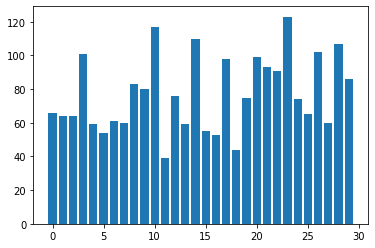

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

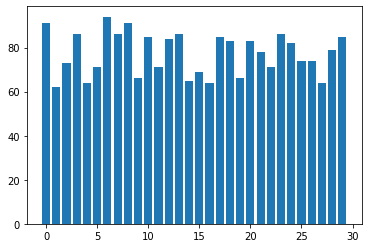

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [14]:
ConvLayer=Conv2D

In [15]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [16]:
from tensorflow.keras import Sequential

In [17]:

class Inception1D(keras.layers.Layer):
    
    def __init__(self, scales):
        super().__init__()
        self.scales=scales
    
    def build(self, input_shape):
        inp=keras.layers.Input(shape=(input_shape[1],input_shape[2]))
        paths=[tf.keras.layers.Conv1D(1,1,padding='same')(inp)]
        for scale in self.scales:
            _path=tf.keras.layers.Conv1D(1,1,padding='same')(inp)
            paths.append(tf.keras.layers.Conv1D(1,scale,padding='same')(inp))
        concat=tf.concat(paths,-1)
        self.model=keras.Model(inputs=[inp],outputs=[concat])
        
    def call(self,x):
        return self.model(x)


In [18]:
class OnlyTimeConvolution(tf.keras.layers.Layer):
    
    def __init__(self,scales,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.tr1=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.tr2=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.inception=Inception1D(scales)
    
    def build(self,input_shape):
        self.num_channels=input_shape[1]
        
    def call(self,x):
        
        x=self.tr1(x)
        x=tf.stack([self.inception(x[:,:,i]) for i in range(self.num_channels)],2)
        x=self.tr2(x)
        return x

In [86]:
120/1500*100

8.0

In [19]:
initial_time_only_conv=Sequential([
    OnlyTimeConvolution(scales=(20,40,60,100)),
    keras.layers.MaxPool2D((1,10)),
    Conv2D(1,(1,1),padding='same'),
    #
],name='initial_time_only_conv_encoder')
model=tf.keras.Sequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    initial_time_only_conv
]).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 150, 1)        232       
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________


In [22]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv,
    #
    ConvBlock(64,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(128,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(150,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(200,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 150, 1)        232       
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 75, 64)        896       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 25, 128)        74368     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 12, 150)        173550    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 12, 200)    

In [23]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [ ]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
72/72 [==============================] - 34s 476ms/step - loss: 3.3301 - accuracy: 0.0825 - F1_0: 0.0486 - F1_1: 0.0920 - F1_2: 0.1106 - F1_3: 0.0244 - F1_4: 0.0174 - F1_5: 0.0375 - F1_6: 0.0411 - F1_7: 0.0213 - F1_8: 0.0033 - F1_9: 0.0322 - F1_10: 0.0473 - F1_11: 0.0797 - F1_12: 0.0708 - F1_13: 0.1554 - F1_14: 0.0178 - F1_15: 0.0574 - F1_16: 0.0176 - F1_17: 0.0984 - F1_18: 0.0220 - F1_19: 0.0103 - F1_20: 0.0720 - F1_21: 0.0166 - F1_22: 0.0736 - F1_23: 0.0675 - F1_24: 0.0738 - F1_25: 0.0391 - F1_26: 0.0765 - F1_27: 0.0432 - F1_28: 0.0475 - F1_29: 0.0092 - val_loss: 3.7565 - val_accuracy: 0.0585 - val_F1_0: 0.0312 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0839 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0357 - val_F1_15: 0.1497 - val_F1_16: 0.0000e+00 - va

In [66]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp3.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [67]:
#model.save_weights('phase_1_weights_100_epochs')

In [68]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [69]:
training_history_file

'training_history/tmp3.json'

In [70]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [71]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [72]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

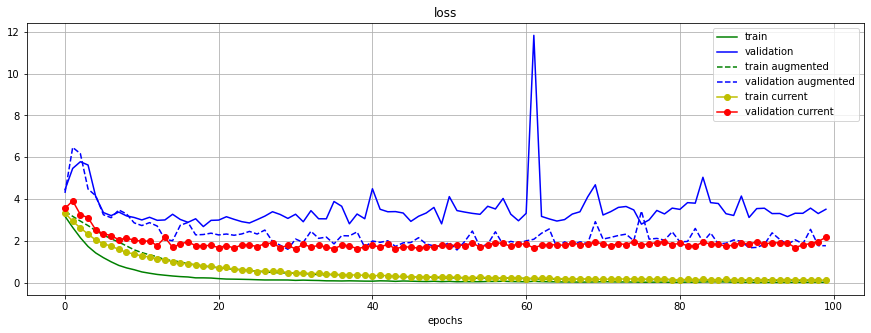

In [73]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

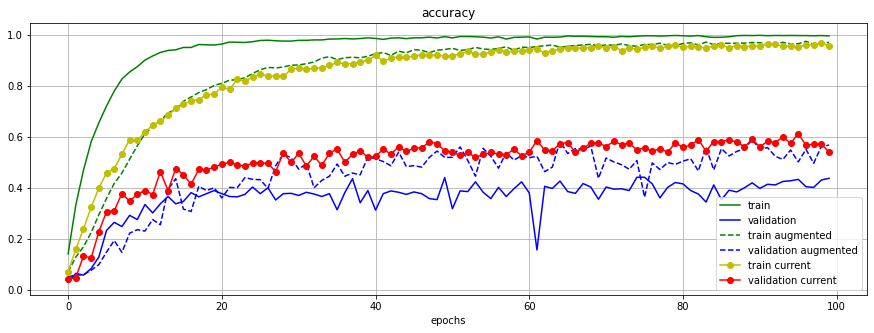

In [74]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

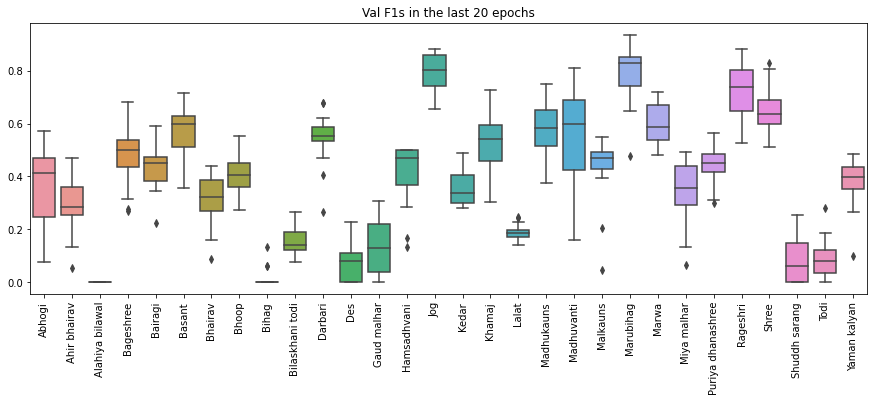

In [75]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

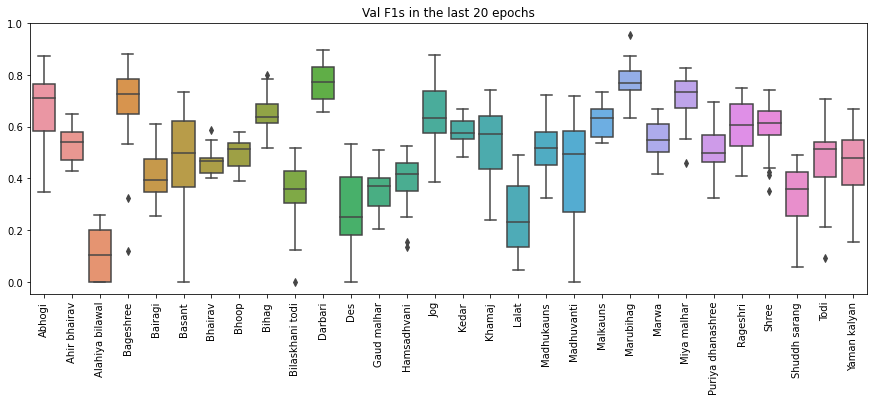

In [76]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()`
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

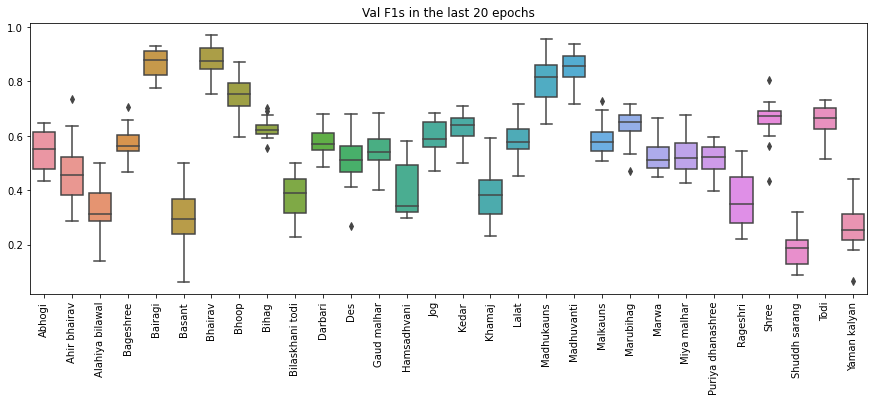

In [77]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

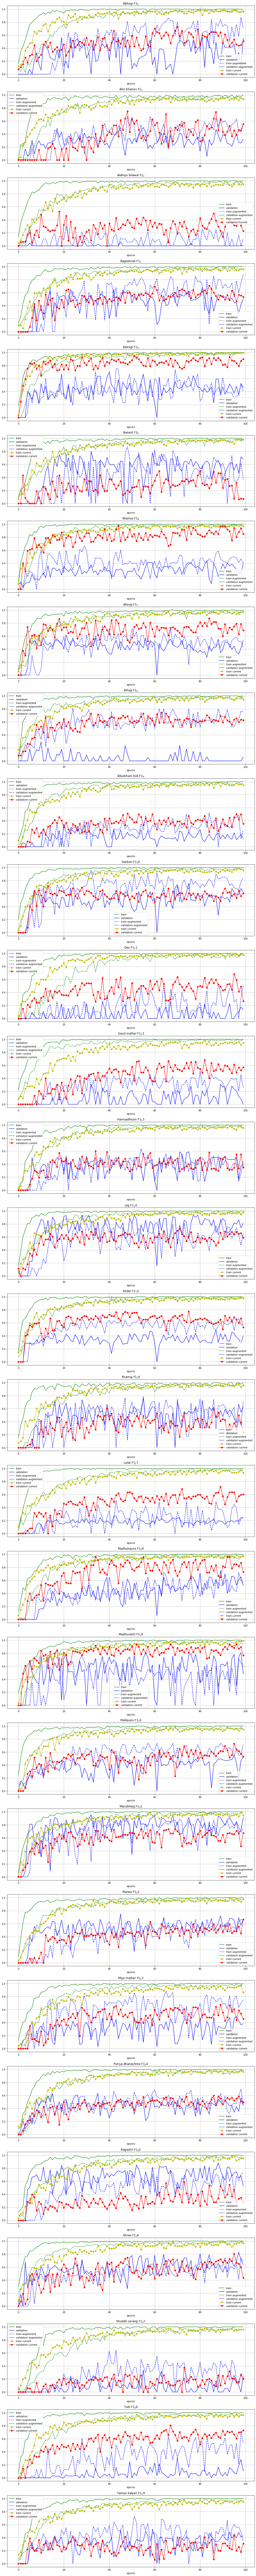

In [79]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [249]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [250]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


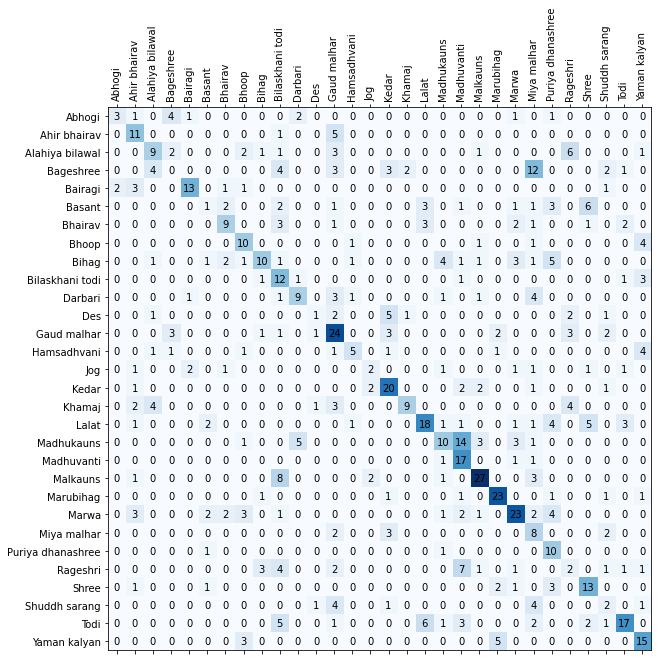

In [251]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [252]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [253]:
precision,recall,f1=process_confusion_matrix(cm)

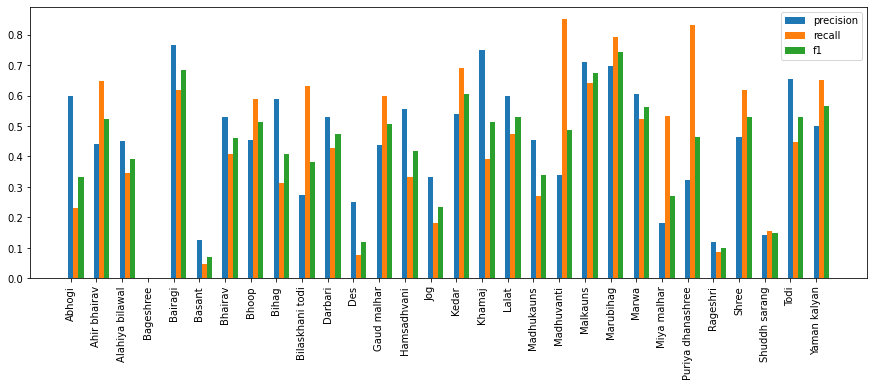

In [254]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()